|--- feature_1 <= 129.50
|   |--- feature_1 <= 65.00
|   |   |--- class: none
|   |--- feature_1 >  65.00
|   |   |--- feature_1 <= 83.00
|   |   |   |--- class: none
|   |   |--- feature_1 >  83.00
|   |   |   |--- class: none
|--- feature_1 >  129.50
|   |--- feature_1 <= 131.00
|   |   |--- class: Reconnaissance
|   |--- feature_1 >  131.00
|   |   |--- feature_1 <= 300.50
|   |   |   |--- class: none
|   |   |--- feature_1 >  300.50
|   |   |   |--- class: Reconnaissance

Accuracy (sklearn): 0.9705184246693631


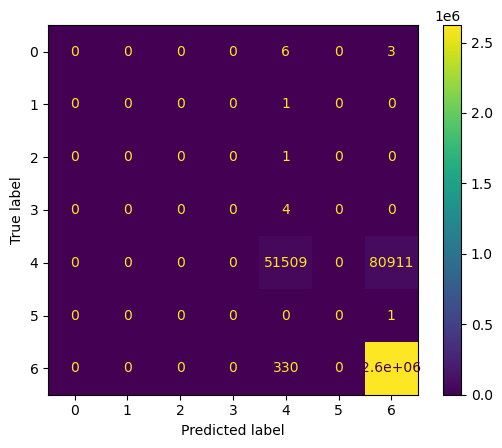

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sqlalchemy import create_engine
import mysql.connector as sql

#connect to the MySQL server
username = 'root'
password = 'Stevenson123!'
hostname = 'localhost'
dbname = 'zeek22'

connection_string = f"mysql+mysqlconnector://{username}:{password}@{hostname}/{dbname}"
engine = create_engine(connection_string)

#query to clean the data
query = """
SELECT label_tactic, 
       service, 
       resp_bytes, 
       resp_ip_bytes, 
       resp_pkts, 
       src_port_zeek, 
       dest_port_zeek, 
       proto
FROM 22data
WHERE label_tactic IS NOT NULL
  AND service IS NOT NULL
  AND resp_bytes IS NOT NULL
  AND resp_ip_bytes IS NOT NULL
  AND resp_pkts IS NOT NULL
  AND src_port_zeek IS NOT NULL
  AND dest_port_zeek IS NOT NULL
  AND proto IS NOT NULL;
"""

df = pd.read_sql(query, engine)

X = df[['resp_pkts', 'resp_bytes']]
y = df['label_tactic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Initialize the tree with `max_leaf_nodes=6`
DTC = DecisionTreeClassifier(max_leaf_nodes=6, random_state=123) 

# Fit the tree to the training data
DTC.fit(X_train, y_train)

# Print the text summary of the tree
DTC_tree = export_text(DTC)
print(DTC_tree)

# Make predictions for the test data
y_pred = DTC.predict(X_test)
 
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
ConfusionMatrixDisplay(cm).plot()
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (sklearn):", accuracy)



In [14]:
from sklearn.ensemble import IsolationForest

if not all(df.dtypes == 'int64'):
    print("Converting non-integer columns to integers.")
    df = df.select_dtypes(include=['number']).astype('int64')

iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.1,  # Adjust based on expected anomaly rate
    random_state=123
)

iso_forest.fit(df)

predictions = iso_forest.predict(df)  # -1 for anomalies, 1 for normal
anomaly_scores = iso_forest.decision_function(df)  # Anomaly scores

results = df.copy()
results['anomaly'] = predictions
results['anomaly_score'] = anomaly_scores

print(results.head())


   resp_bytes  resp_ip_bytes  resp_pkts  src_port_zeek  dest_port_zeek  \
0           0              0          0             68              67   
1          48            160          4          50891              53   
2          48            160          4          45406              53   
3          60            200          5          50893              53   
4          48            160          4          41214              53   

   anomaly  anomaly_score  
0       -1      -0.070086  
1        1       0.002355  
2        1       0.004339  
3       -1      -0.086471  
4       -1      -0.008793  


Labels: [ 0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0
  0  0  0  2  0  0  0  0  0  1  1  1  0  0  0  0  0  0  0  1  1  0  0  0
  0  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
  0  0  1  0  0  0  0  0  0  0  2  0  0  0  0  0  2  0  1  0  0  0  0  0
  0  2  0  0 -1  1  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  0  1  1  0  0  0  2  2  0  0  0  0  0  0  0  2  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0  0  0  2  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  2  0  0  1  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  2  1  0  0  0  0 -1  0  0  0  0  0
  0  1  0  2  0  1  0  0  0  0  0  0  0  0 

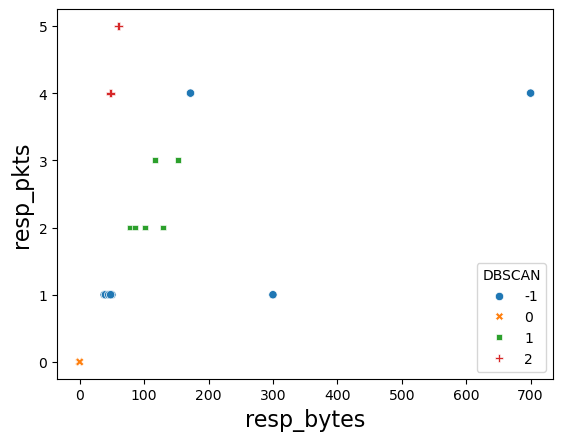

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
import numpy as np  

data = df.sample(500, random_state=123)

# Use StandardScaler() to standardize input features
X = data[['resp_bytes', 'resp_pkts']]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

# Apply DBSCAN with epsilon=1 and min_samples=8   
dbscan = DBSCAN(eps=1, min_samples=8)
dbscan = dbscan.fit(X)

# Print the cluster labels and core point indices
print('Labels:', dbscan.labels_)
core_points = np.sum(dbscan.core_sample_indices_ >= 0)
print('Core points:', dbscan.core_sample_indices_)
print('Number of core points:', core_points)

# Calculate number of outliers (noise points labeled as -1)
outliers = np.sum(dbscan.labels_ == -1)
print('Number of outliers:', outliers)

# Add the cluster labels to the dataset as strings
data['clusters'] = dbscan.labels_.astype(str)

# Sort by cluster label (for plotting purposes)
data.sort_values(by='clusters', inplace=True)

# Plot clusters on the original data
p = sns.scatterplot(data=data, x='resp_bytes',
                    y='resp_pkts', hue='clusters',
                    style='clusters')
p.set_xlabel('resp_bytes', fontsize=16)
p.set_ylabel('resp_pkts', fontsize=16)
p.legend(title='DBSCAN')
plt.show()
engine.dispose()